# Clustering de documents

## Imports

In [29]:
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [30]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dohakarroumi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
data_path = "../data/camille_Guerre_de_Coree/"

## Choisir une décennie

In [32]:
DECADE = '1951'

## Charger tous les  fichiers de la décennie et en créer une liste de textes

In [33]:
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

In [34]:
# Exemple de fichiers
files[:500]

['KB_JB838_1950-07-01_01-00003.txt',
 'KB_JB838_1950-07-05_01-00003.txt',
 'KB_JB838_1950-07-06_01-00003.txt',
 'KB_JB838_1950-07-07_01-00001.txt',
 'KB_JB838_1950-07-08_01-00003.txt',
 'KB_JB838_1950-07-09_01-00001.txt',
 'KB_JB838_1950-07-12_01-00001.txt',
 'KB_JB838_1950-07-13_01-00001.txt',
 'KB_JB838_1950-07-13_01-00002.txt',
 'KB_JB838_1950-07-15_01-00001.txt',
 'KB_JB838_1950-07-16_01-00001.txt',
 'KB_JB838_1950-07-18_01-00003.txt',
 'KB_JB838_1950-07-19_01-00001.txt',
 'KB_JB838_1950-07-20_01-00001.txt',
 'KB_JB838_1950-07-25_01-00003.txt',
 'KB_JB838_1950-07-28_01-00001.txt',
 'KB_JB838_1950-07-30_01-00005.txt',
 'KB_JB838_1950-08-05_01-00003.txt',
 'KB_JB838_1950-08-06_01-00003.txt',
 'KB_JB838_1950-08-07_01-00001.txt',
 'KB_JB838_1950-08-07_01-00003.txt',
 'KB_JB838_1950-08-08_01-00001.txt',
 'KB_JB838_1950-08-10_01-00001.txt',
 'KB_JB838_1950-08-13_01-00001.txt',
 'KB_JB838_1950-08-16_01-00002.txt',
 'KB_JB838_1950-08-18_01-00001.txt',
 'KB_JB838_1950-08-21_01-00003.txt',
 

In [35]:
texts = [open(data_path + f).read() for f in files]

In [36]:
# Exemple de textes
texts[0][:400]

'Une colonne dée nordiste a percé les lignes jie défense du Han L’aérodrome de won est menacé Les bombardiers américains réagissent énergiquement Washington, 30 juin (A,Pl Les blindes de la Corée du Ifyrd ont percé la ligne de défense sudiste établie sur le fledve Ha»; et ont ainsi disposé de la principale résistance à leur avance vers le sud. J Les forces de la Corée du Sud, déjà vivement éprouvée'

## Vectoriser les documents à l'aide de TF-IDF

In [37]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

### Instancier le modèle TF-IDF avec ses arguments

In [38]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

### Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

In [39]:
tfidf_vectors = vectorizer.fit_transform(texts)

In [40]:
# Détail de la matrice
tfidf_vectors

<500x3751 sparse matrix of type '<class 'numpy.float64'>'
	with 395615 stored elements in Compressed Sparse Row format>

### Imprimer le vecteur tf-IDF du premier document

In [41]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

spaak         0.293198
nordistes     0.256164
séoul         0.200038
arthur        0.190693
chasseurs     0.177354
                ...   
favorable     0.000000
favorables    0.000000
favoriser     0.000000
femmes        0.000000
★★★           0.000000
Length: 3751, dtype: float64

## Comprendre les vecteurs et leurs "distances"

In [42]:
cosine([1, 2, 3], [1, 2, 3])

0

In [43]:
cosine([1, 2, 3], [1, 2, 2])

0.02004211298777725

In [44]:
cosine([1, 2, 3], [2, 2, 2])

0.07417990022744858

### Tests sur nos documents

In [45]:
tfidf_array = tfidf_vectors.toarray()

In [46]:
# Vecteur du document 0
tfidf_array[0]

array([0.02344002, 0.02866354, 0.        , ..., 0.02434208, 0.        ,
       0.        ])

In [47]:
# Vecteur du document 1
tfidf_array[1]

array([0., 0., 0., ..., 0., 0., 0.])

In [48]:
cosine(tfidf_array[0], tfidf_array[1])

0.6875384029461088

## Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

Pour en savoir plus sur le KMeans clustering :
- https://medium.com/dataseries/k-means-clustering-explained-visually-in-5-minutes-b900cc69d175

### Définir un nombre de clusters

In [49]:
N_CLUSTERS = 5

### Instancier le modèle K-Means et ses arguments

In [50]:
km_model = KMeans(n_clusters=N_CLUSTERS)

### Appliquer le clustering à l'aide de la fonction `fit_predict`

In [51]:
clusters = km_model.fit_predict(tfidf_vectors)

In [52]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [53]:
pprint(dict(clustering))

{0: ['KB_JB838_1950-07-07_01-00001.txt',
     'KB_JB838_1950-07-09_01-00001.txt',
     'KB_JB838_1950-07-12_01-00001.txt',
     'KB_JB838_1950-07-13_01-00001.txt',
     'KB_JB838_1950-07-15_01-00001.txt',
     'KB_JB838_1950-07-16_01-00001.txt',
     'KB_JB838_1950-07-19_01-00001.txt',
     'KB_JB838_1950-07-28_01-00001.txt',
     'KB_JB838_1950-08-07_01-00001.txt',
     'KB_JB838_1950-08-08_01-00001.txt',
     'KB_JB838_1950-08-10_01-00001.txt',
     'KB_JB838_1950-08-13_01-00001.txt',
     'KB_JB838_1950-08-18_01-00001.txt',
     'KB_JB838_1950-08-22_01-00001.txt',
     'KB_JB838_1950-08-30_01-00001.txt',
     'KB_JB838_1950-08-30_01-00002.txt',
     'KB_JB838_1950-08-31_01-00001.txt',
     'KB_JB838_1950-09-01_01-00001.txt',
     'KB_JB838_1950-09-02_01-00001.txt',
     'KB_JB838_1950-09-03_01-00001.txt',
     'KB_JB838_1950-09-07_01-00001.txt',
     'KB_JB838_1950-09-12_01-00001.txt',
     'KB_JB838_1950-09-13_01-00001.txt',
     'KB_JB838_1950-09-14_01-00001.txt',
     'KB_JB838_1

## Visualiser les clusters

### Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA
Cette étape est nécessaire afin de visualiser les documents dans un espace 2D

https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales

In [54]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [55]:
reduced_vectors[:10]

array([[ 0.15393947, -0.18889136],
       [ 0.12334432, -0.02799661],
       [ 0.15928099, -0.06817975],
       [-0.10379537, -0.13799341],
       [ 0.17902768, -0.13343777],
       [-0.15322628, -0.14718032],
       [-0.07780346, -0.16970971],
       [-0.07971081, -0.10859804],
       [-0.06492733, -0.04855724],
       [-0.04902592, -0.13374091]])

### Générer le plot

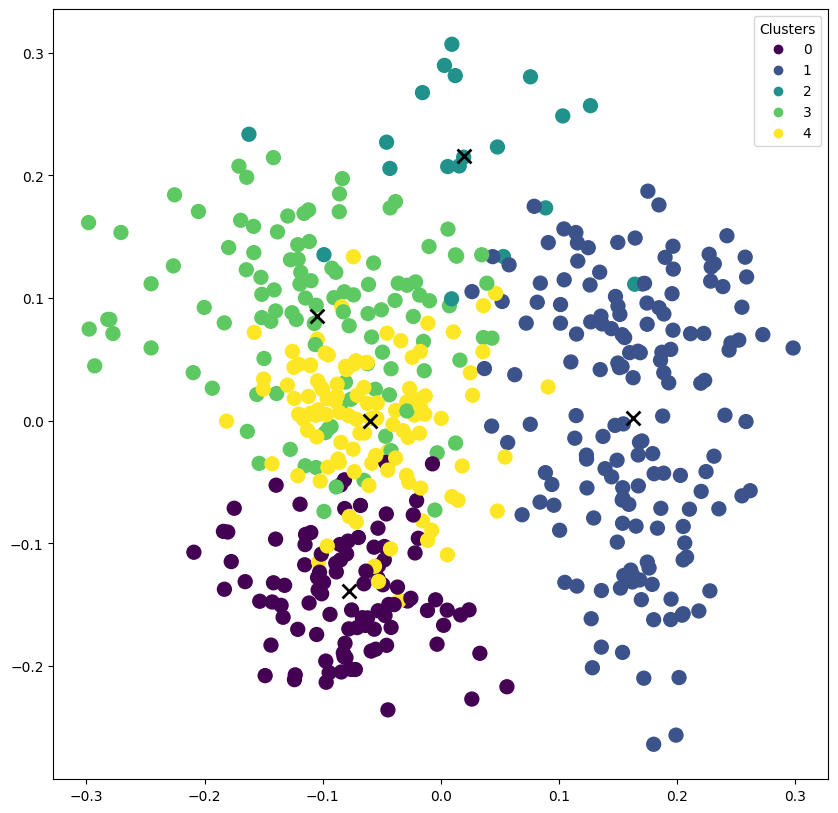

In [56]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")